# Galaxy Decomposition

In [72]:
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np
from scipy.stats import binned_statistic
from auriga.snapshot import Snapshot
from auriga.images import figure_setup
from auriga.paths import Paths
from auriga.parser import parse
from auriga.settings import Settings

In [30]:
figure_setup()

## The Decomposition Phase-Space

In [31]:
def read_data(simulation: str) -> tuple:
    """
    This method returns the circularity and the normalized potential for the
    stars in the main object of the simulation.

    Parameters
    ----------
    simulation : str
        The simulation to consider.

    Returns
    -------
    tuple
        The circularity and normalized potential.
    """
    s = Snapshot(simulation=simulation,
                 loadonlytype=[0, 1, 2, 3, 4, 5])
    s.add_circularity()
    s.add_reference_to_potential()
    s.add_normalized_potential()
    s.tag_particles_by_region(disc_std_circ=1.0,
                              disc_min_circ=0.4,
                              cold_disc_delta_circ=0.25,
                              bulge_max_specific_energy=-0.75)

    is_real_star = (s.type == 4) & (s.stellar_formation_time > 0)
    is_main_obj = (s.halo == s.halo_idx) & (s.subhalo == s.subhalo_idx)

    return (s.circularity[is_real_star & is_main_obj],
        s.normalized_potential[is_real_star & is_main_obj],
        s.region_tag[is_real_star & is_main_obj])

In [32]:
def plot_decomp_phases_for_galaxy(simulation: str):
    """
    This method creates a plot of the phase space for galactic decomposition
    - the circularity in the x-axis and the normalized gravitational
    potential in the y-axis.

    Parameters
    ----------
    simulation : str
        The simulation to plot.
    """

    fig = plt.figure(figsize=(3.0, 3.0))
    gs = fig.add_gridspec(nrows=1, ncols=1, hspace=0.0, wspace=0.0)
    ax = gs.subplots(sharex=True, sharey=True)

    ax.label_outer()
    ax.tick_params(which='both', direction="in")
    ax.set_xlim(-1.4, 1.4)
    ax.set_ylim(-1, 0)
    ax.set_xticks([-1, 0, 1])
    ax.set_yticks([-1, -.8, -.6, -.4, -.2, 0])
    ax.set_xlabel(r'$\epsilon = j_z \, j_\mathrm{circ}^{-1}$')
    ax.set_ylabel(r'$\tilde{e} = e \, \left| e \right|_\mathrm{max}^{-1}$')

    circularity, potential, _ = read_data(simulation=simulation)
    _, _, _, im = ax.hist2d(circularity,
                            potential,
                            cmap='nipy_spectral',
                            bins=200,
                            range=[ax.get_xlim(), ax.get_ylim()],
                            norm=mcolors.LogNorm(vmin=1E0, vmax=1E3))

    cbar = fig.colorbar(im, ax=ax, orientation='vertical',
                        label=r'$N_\mathrm{stars}$',
                        pad=0)
    cbar.ax.set_yticks([1E0, 1E1, 1E2, 1E3])

    ax.text(x=ax.get_xlim()[0],
            y=ax.get_ylim()[1],
            s=simulation.upper(),
            size=8.0,
            ha='left', va='bottom',
            )

    plt.show()

In [33]:
def plot_decomp_phases_for_galaxy_by_region(simulation: str):
    """
    This method creates a plot of the phase space for galactic decomposition
    - the circularity in the x-axis and the normalized gravitational
    potential in the y-axis. Each panel shows the distribution for a given
    component.

    Parameters
    ----------
    simulation : str
        The simulation to plot.
    """

    fig = plt.figure(figsize=(7.4, 2.0))
    gs = fig.add_gridspec(nrows=1, ncols=4, hspace=0.0, wspace=0.0)
    axs = gs.subplots(sharex=True, sharey=True)

    for ax in axs.flat:
        ax.tick_params(which='both', direction="in")
        ax.set_xlim(-1.4, 1.4)
        ax.set_ylim(-1, 0)
        ax.set_xticks([-1, 0, 1])
        ax.set_yticks([-1, -.8, -.6, -.4, -.2, 0])
        ax.set_xlabel(r'$\epsilon = j_z \, j_\mathrm{circ}^{-1}$')
        if ax.get_subplotspec().is_first_col():
            ax.set_ylabel(
                r'$\tilde{e} = e \, \left| e \right|_\mathrm{max}^{-1}$')

    circularity, potential, region_tag = read_data(simulation=simulation)
    for idx, tag in enumerate(np.unique(region_tag)):
        is_region = (region_tag == tag)
        _, _, _, im = axs[idx].hist2d(
            circularity[is_region],
            potential[is_region],
            cmap='nipy_spectral',
            bins=200,
            range=[axs[idx].get_xlim(), axs[idx].get_ylim()],
            norm=mcolors.LogNorm(vmin=1E0, vmax=1E3))

    cbar = fig.colorbar(im, ax=axs[-1], orientation='vertical',
                        label=r'$N_\mathrm{stars}$',
                        pad=0)
    cbar.ax.set_yticks([1E0, 1E1, 1E2, 1E3])

    axs[0].text(x=axs[0].get_xlim()[0],
                y=axs[0].get_ylim()[1],
                s=simulation.upper(),
                size=8.0,
                ha='left', va='bottom',
                )

    plt.show()

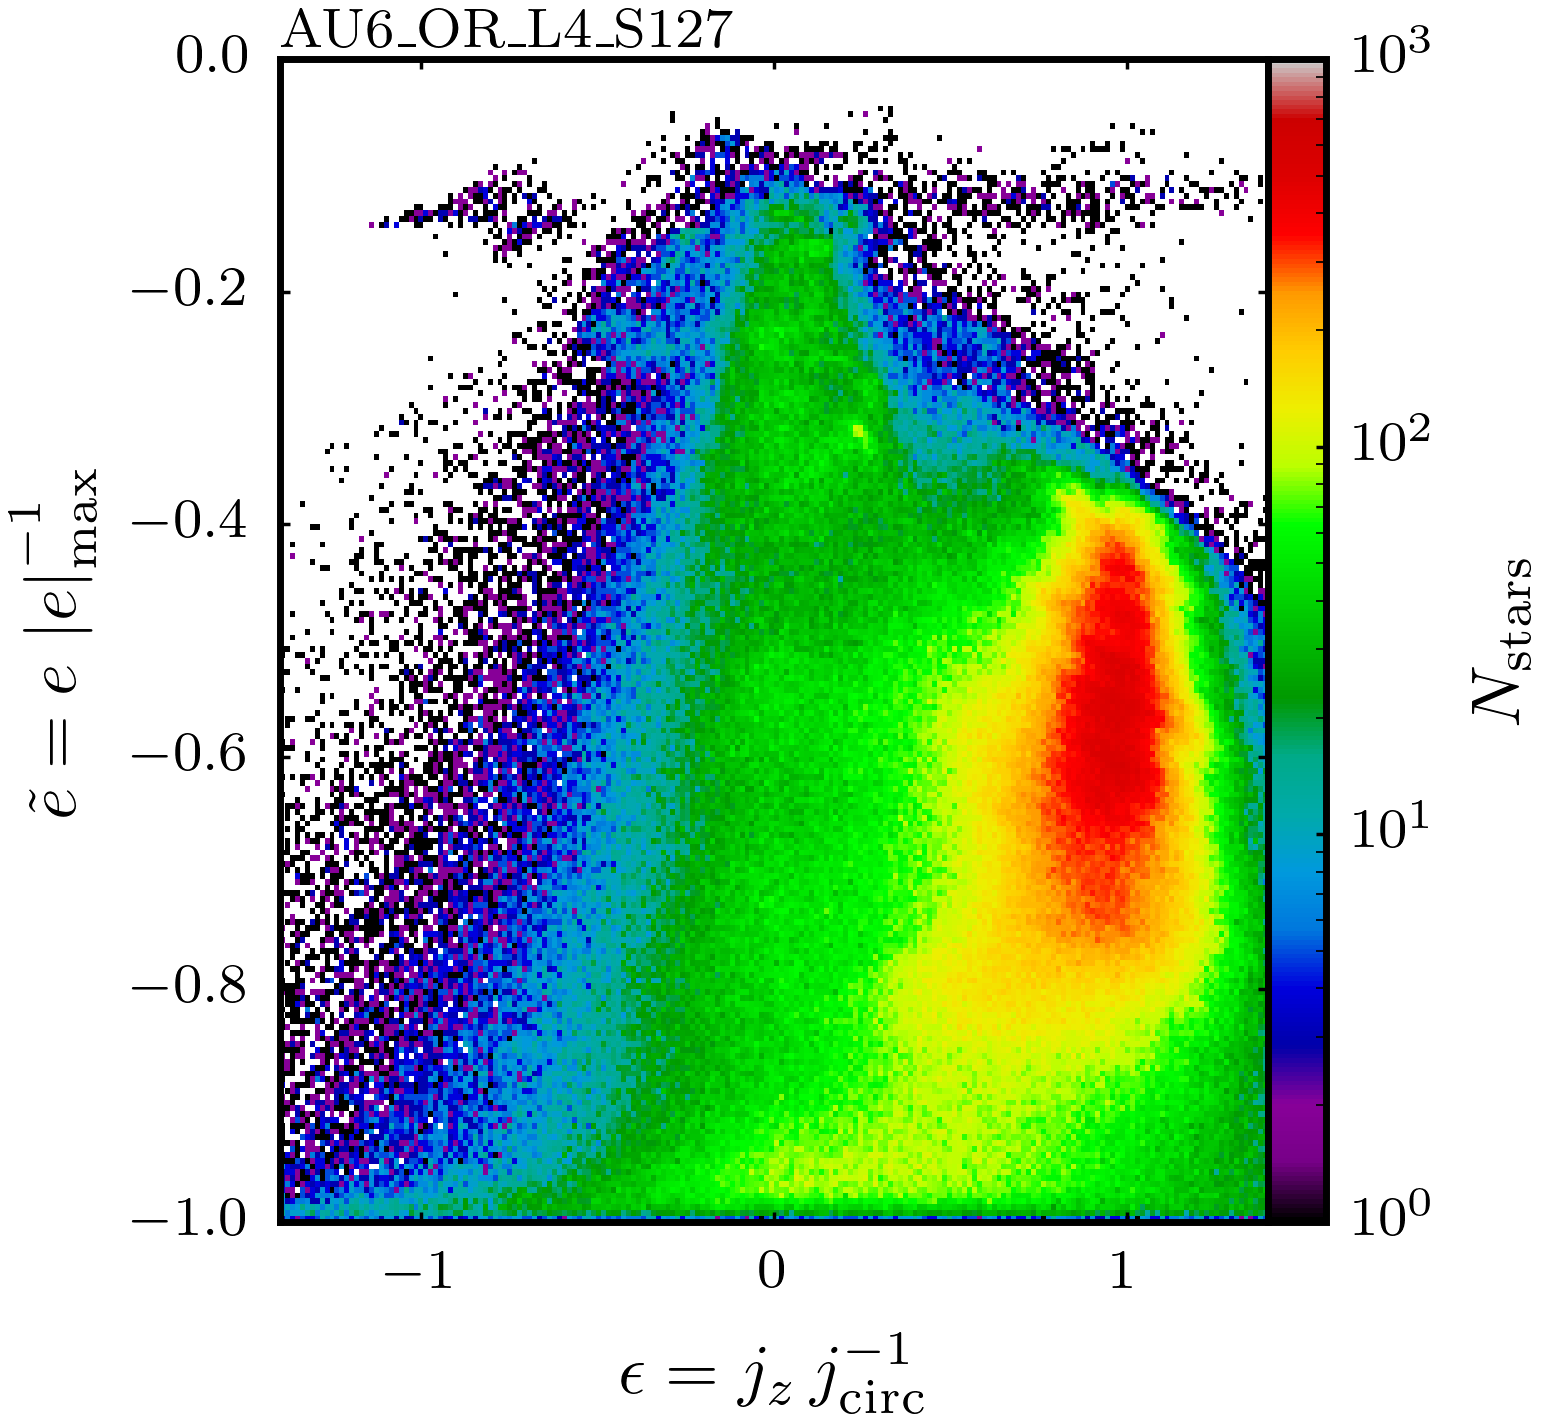

In [34]:
plot_decomp_phases_for_galaxy(simulation="au6_or_l4_s127")

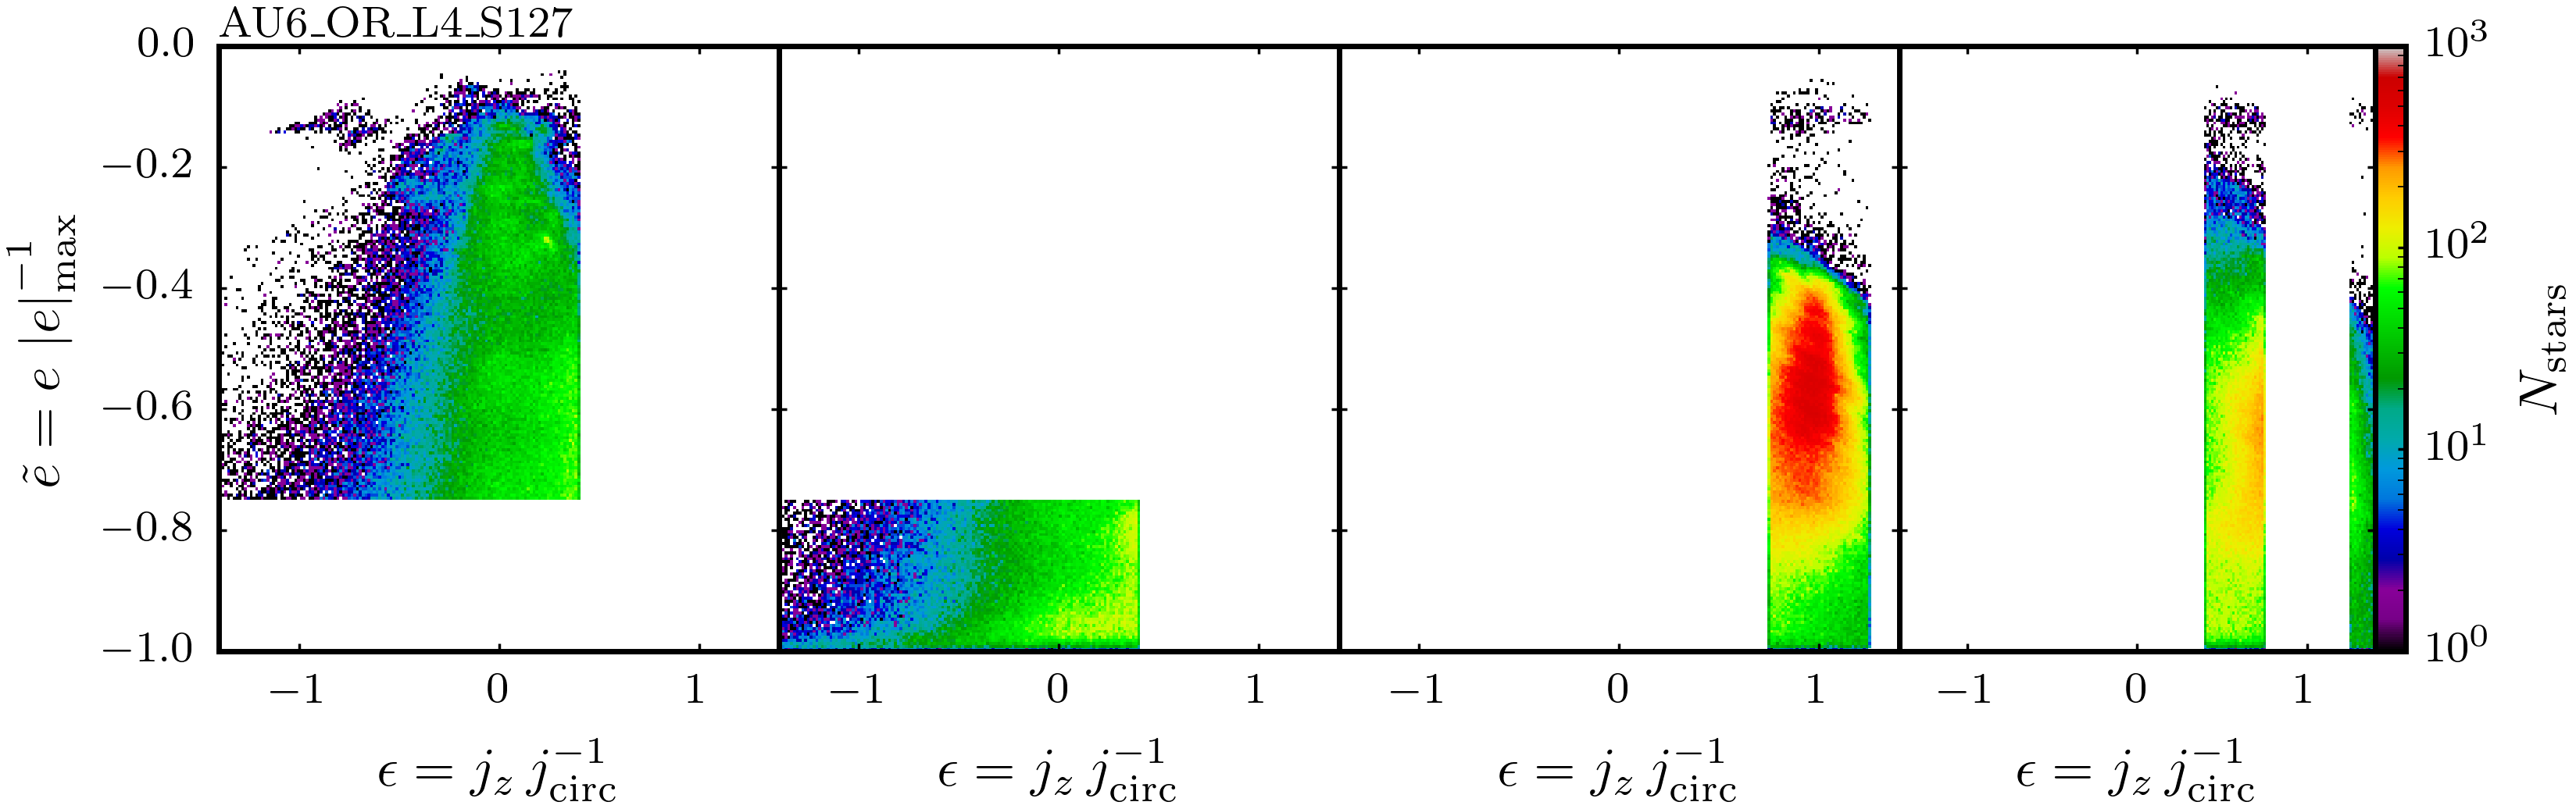

In [35]:
plot_decomp_phases_for_galaxy_by_region(simulation="au6_or_l4_s127")

## Stellar Velocities

In [36]:
def read_data_vels(simulation: str) -> tuple:
    """
    This method returns the region tag, velocities and radius of the disc plane
    of the stars in the main object of the simulation.

    Parameters
    ----------
    simulation : str
        The simulation to consider.

    Returns
    -------
    tuple
        The properties.
    """
    s = Snapshot(simulation=simulation,
                 loadonlytype=[0, 1, 2, 3, 4, 5])
    s.add_circularity()
    s.add_reference_to_potential()
    s.add_normalized_potential()
    s.tag_particles_by_region(disc_std_circ=1.0,
                              disc_min_circ=0.4,
                              cold_disc_delta_circ=0.25,
                              bulge_max_specific_energy=-0.75)

    is_real_star = (s.type == 4) & (s.stellar_formation_time > 0)
    is_main_obj = (s.halo == s.halo_idx) & (s.subhalo == s.subhalo_idx)

    v_z_signed = s.vel[:, 2] * np.sign(s.pos[:, 2])

    return (s.region_tag[is_real_star & is_main_obj],
        s.rho[is_real_star & is_main_obj],
        s.v_rho[is_real_star & is_main_obj],
        s.v_phi[is_real_star & is_main_obj],
        v_z_signed[is_real_star & is_main_obj],
        np.linalg.norm(s.vel, axis=1)[is_real_star & is_main_obj],)

In [87]:
def plot_velocities_by_region(simulation: str):
    """
    This method creates a plot of the velocities as a function of radius in
    the disc plane for each component.

    Parameters
    ----------
    simulation : str
        The simulation to plot.
    """

    fig = plt.figure(figsize=(7.4, 2.0))
    gs = fig.add_gridspec(nrows=1, ncols=4, hspace=0.0, wspace=0.0)
    axs = gs.subplots(sharex=True, sharey=True)

    for ax in axs.flat:
        ax.grid(True, ls='-', lw=0.25, c='silver', zorder=-20)
        ax.tick_params(which='both', direction="in")
        ax.set_xlim(1, 200)
        ax.set_ylim(-100, 250)
        ax.set_xscale('log')
        ax.set_xticks([1, 10, 100])
        ax.set_yticks([-50, 0, 50, 100, 150, 200])
        ax.set_xticklabels([1, 10, 100])
        ax.set_xlabel(r'$r_{xy}$ [ckpc]')
        ax.set_ylabel(r'Velocity [$\mathrm{km} \, \mathrm{s}^{-1}]$')
        ax.label_outer()

    region_tag, rho, v_rho, v_phi, vz, vel = read_data_vels(
        simulation=simulation)
    for idx, tag in enumerate(np.unique(region_tag)):
        is_region = (region_tag == tag)
        n_bins = np.diff(axs[idx].get_xlim())
        v_rho_bind, bin_edges, _ = binned_statistic(
            x=rho[is_region],
            values=v_rho[is_region],
            bins=n_bins,
            range=axs[idx].get_xlim())
        bin_centers = bin_edges[1:] - np.diff(bin_edges)[0] / 2
        axs[idx].plot(bin_centers[np.isfinite(v_rho_bind)],
                      v_rho_bind[np.isfinite(v_rho_bind)],
                      lw=.75, label="$v_r$", zorder=10, c="tab:green")

        v_z_bind, _, _ = binned_statistic(
            x=rho[is_region],
            values=vz[is_region],
            bins=n_bins,
            range=axs[idx].get_xlim())
        axs[idx].plot(bin_centers[np.isfinite(v_z_bind)],
                      v_z_bind[np.isfinite(v_z_bind)],
                      lw=.75, label="$v_z$", zorder=10, c="tab:red")

        v_phi_bind, _, _ = binned_statistic(
            x=rho[is_region],
            values=v_phi[is_region],
            bins=n_bins,
            range=axs[idx].get_xlim())
        axs[idx].plot(bin_centers[np.isfinite(v_phi_bind)],
                      v_phi_bind[np.isfinite(v_phi_bind)],
                      lw=.75, label="$v_\phi$", zorder=10, c="tab:blue")

        v_std_bind, _, _ = binned_statistic(
            x=rho[is_region],
            values=vel[is_region],
            statistic="std",
            bins=n_bins,
            range=axs[idx].get_xlim())
        axs[idx].plot(bin_centers[v_std_bind > 0],
                      v_std_bind[v_std_bind > 0],
                      zorder=10, lw=.75, label="$\sigma_v$", c="black")

        settings = Settings()
        axs[idx].text(x=1.5,
                      y=-80,
                      s=settings.component_labels[settings.components[idx]],
                      size=8.0,
                      ha='left', va='bottom',
                      )

    axs[0].legend(loc="upper left", framealpha=0, fontsize=6.0)

    axs[0].text(x=axs[0].get_xlim()[0],
                y=axs[0].get_ylim()[1],
                s=simulation.upper(),
                size=8.0,
                ha='left', va='bottom',
                )

    plt.show()

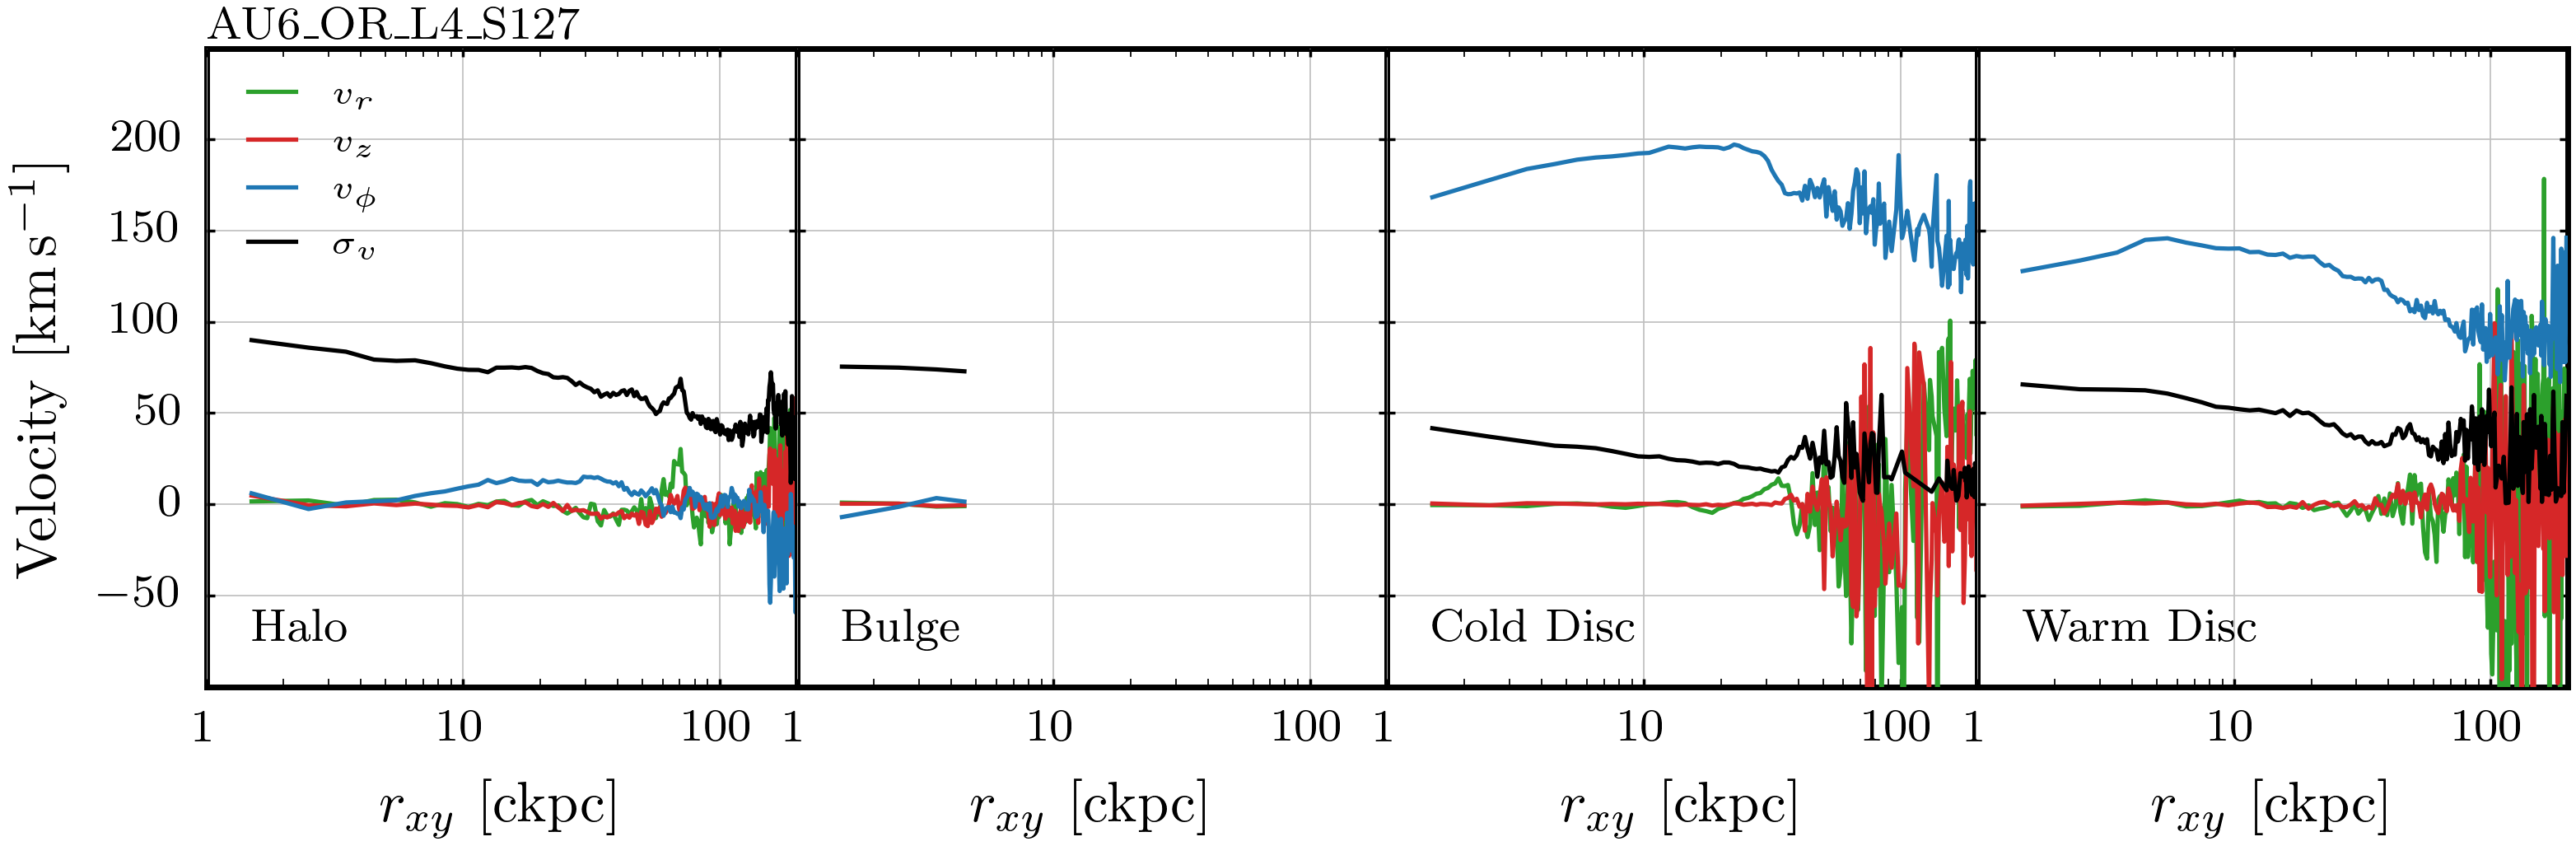

In [88]:
plot_velocities_by_region(simulation="au6_or_l4_s127")

## Radial and Vertical Distribution of Particles

In [98]:
def read_data_pos(simulation: str) -> tuple:
    """
    This method returns the region tag, radius in the disc plane and
    position in the z-axis for the stars in the main object.

    Parameters
    ----------
    simulation : str
        The simulation to consider.

    Returns
    -------
    tuple
        The properties.
    """
    s = Snapshot(simulation=simulation,
                 loadonlytype=[0, 1, 2, 3, 4, 5])
    s.add_circularity()
    s.add_reference_to_potential()
    s.add_normalized_potential()
    s.tag_particles_by_region(disc_std_circ=1.0,
                              disc_min_circ=0.4,
                              cold_disc_delta_circ=0.25,
                              bulge_max_specific_energy=-0.75)

    is_real_star = (s.type == 4) & (s.stellar_formation_time > 0)
    is_main_obj = (s.halo == s.halo_idx) & (s.subhalo == s.subhalo_idx)

    return (s.region_tag[is_real_star & is_main_obj],
        s.rho[is_real_star & is_main_obj],
        s.pos[is_real_star & is_main_obj, 2],)

In [109]:
def plot_part_distribution_by_region(simulation: str):
    """
    This method creates a plot of the velocities as a function of radius in
    the disc plane for each component.

    Parameters
    ----------
    simulation : str
        The simulation to plot.
    """

    fig = plt.figure(figsize=(3.7, 2.0))
    gs = fig.add_gridspec(nrows=1, ncols=2, hspace=0.0, wspace=0.0)
    axs = gs.subplots(sharex=False, sharey=True)

    for ax in axs.flat:
        ax.grid(True, ls='-', lw=0.25, c='silver', zorder=-20)
        ax.tick_params(which='both', direction="in")
        ax.set_ylabel('PDF')
        ax.label_outer()

    axs[0].set_xlim(0, 50)
    axs[0].set_xticks([0, 10, 20, 30, 40])
    axs[1].set_xlim(-10, 10)
    axs[1].set_xticks([-10, -5, 0, 5, 10])
    axs[0].set_xlabel(r'$r_{xy}$ [ckpc]')
    axs[1].set_xlabel(r'$z$ [ckpc]')

    settings = Settings()
    region_tag, rho, z = read_data_pos(simulation=simulation)
    for idx, tag in enumerate(np.unique(region_tag)):
        is_region = (region_tag == tag)
        axs[0].hist(x=rho[is_region],
                    bins=100,
                    range=axs[0].get_xlim(),
                    histtype="step",
                    density=True,
                    color=settings.component_colors[settings.components[idx]],
                    label=settings.component_labels[settings.components[idx]])
        axs[1].hist(x=z[is_region],
                    bins=100,
                    range=axs[1].get_xlim(),
                    histtype="step",
                    density=True,
                    color=settings.component_colors[settings.components[idx]])

    axs[0].legend(loc="upper left", framealpha=0, fontsize=6.0)

    axs[0].text(x=axs[0].get_xlim()[0],
                y=axs[0].get_ylim()[1],
                s=simulation.upper(),
                size=8.0,
                ha='left', va='bottom',
                )

    plt.show()

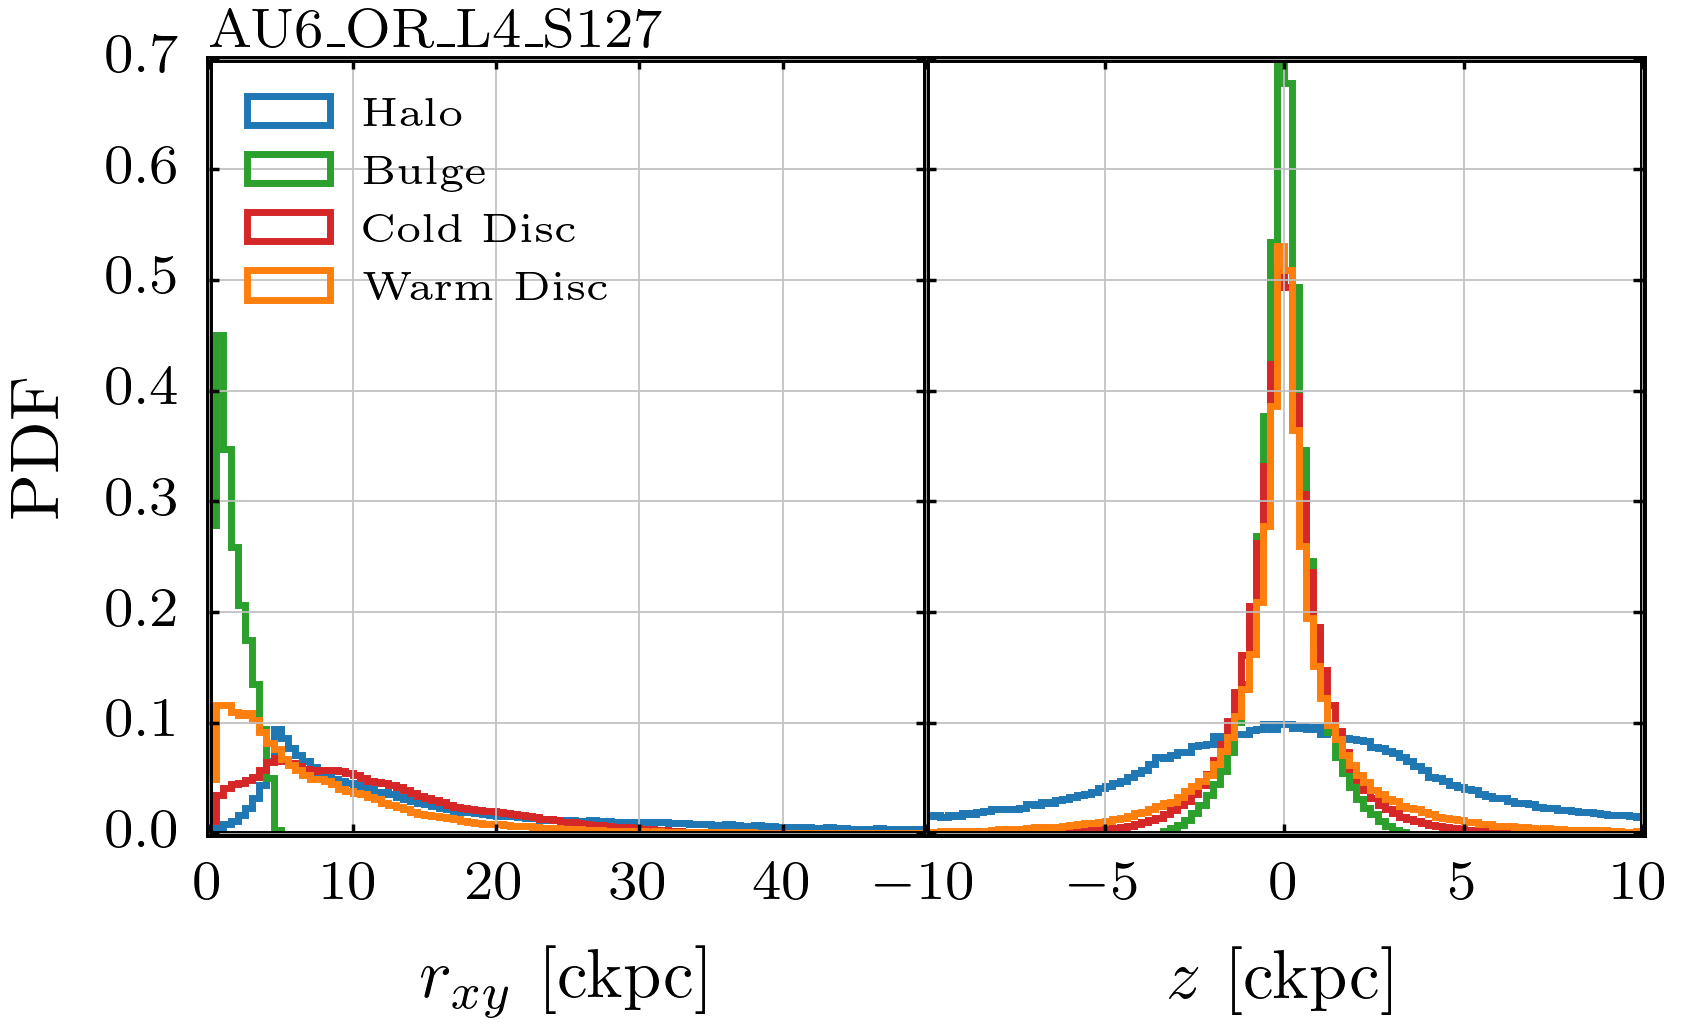

In [110]:
plot_part_distribution_by_region(simulation="au6_or_l4_s127")

In [132]:
def plot_height_vs_radius_for_halo(simulation: str):
    """
    This method creates a plot of the velocities as a function of radius in
    the disc plane for each component.

    Parameters
    ----------
    simulation : str
        The simulation to plot.
    """

    fig = plt.figure(figsize=(2.0, 2.0))
    gs = fig.add_gridspec(nrows=1, ncols=1, hspace=0.0, wspace=0.0)
    ax = gs.subplots(sharex=False, sharey=True)

    ax.grid(True, ls='-', lw=0.25, c='silver', zorder=-20)
    ax.tick_params(which='both', direction="in")
    ax.label_outer()
    ax.set_xlim(0, 5)
    ax.set_xticks([0, 1, 2, 3, 4, 5])
    ax.set_ylim(-25, 25)
    ax.set_yticks([-20, -10, -5, 0, 5, 10, 20])
    ax.set_xlabel(r'$r_{xy}$ [ckpc]')
    ax.set_ylabel(r'$z$ [ckpc]')

    settings = Settings()
    region_tag, rho, z = read_data_pos(simulation=simulation)
    is_region = (region_tag == 0)
    ax.scatter(x=rho[is_region],
               y=z[is_region],
               s=0.1,
               zorder=10,
               color=settings.component_colors[settings.components[0]])

    ax.text(x=ax.get_xlim()[0],
            y=ax.get_ylim()[1],
            s=simulation.upper(),
            size=8.0,
            ha='left', va='bottom',
            )

    plt.show()

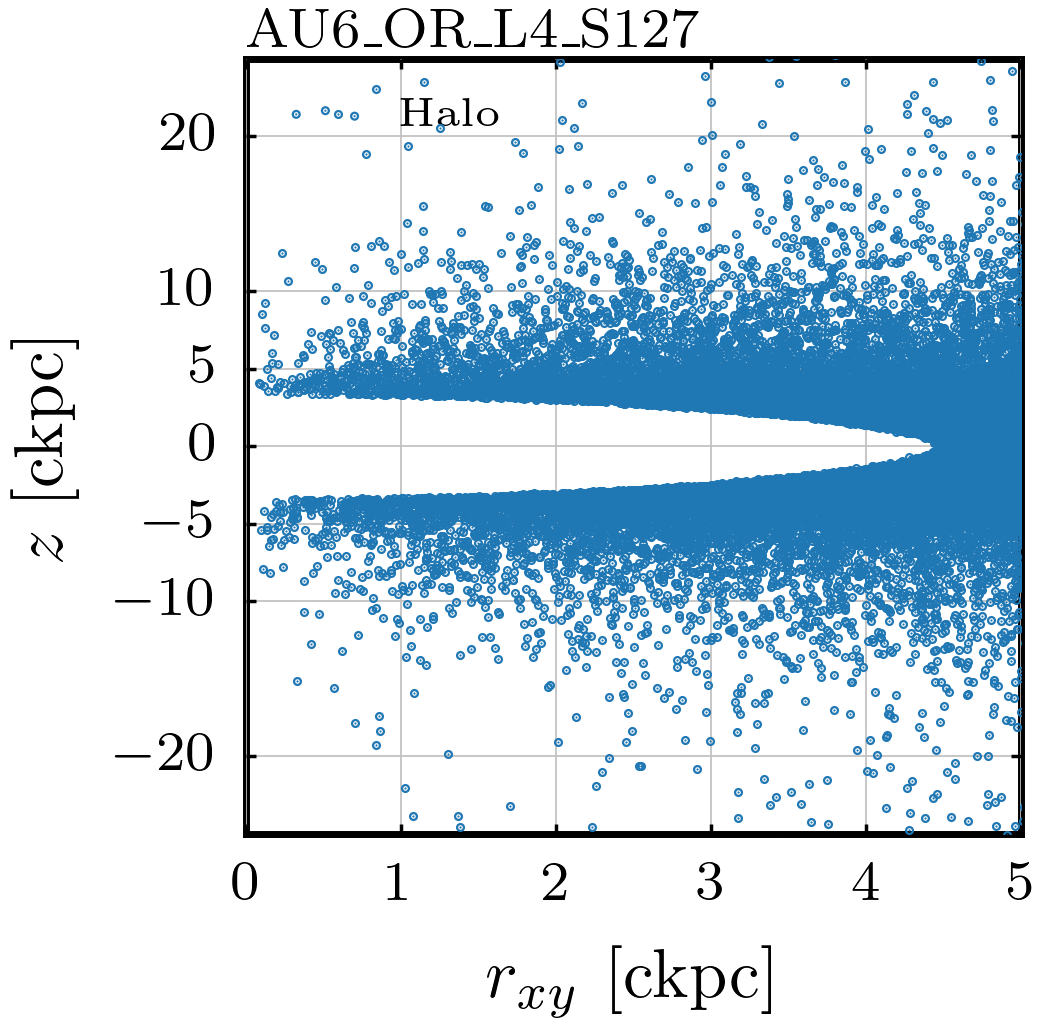

In [133]:
plot_height_vs_radius_for_halo(simulation="au6_or_l4_s127")